<p style="text-align:center">
    <a href="https://www.ict.mahidol.ac.th/en/" target="_blank">
    <img src="https://www3.ict.mahidol.ac.th/ICTSurveysV2/Content/image/MUICT2.png" width="400" alt="Faculty of ICT">
    </a>
</p>

# Lab09: ML Basics: Unsupervised Learning - Tutorial


```









```

# Load Imports and Library of Helper Functions

- Run this cell to use its functions later. Contains plotting functions.

In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial import Voronoi, voronoi_plot_2d
import warnings
warnings.simplefilter("ignore", UserWarning)


def one_hot_encode(df, columns_to_encode):
    df_encoded = df.copy()  # Create a copy to avoid modifying the original DataFrame
    for col in columns_to_encode:
        if col in df_encoded.columns: #Check if the column exists.
            one_hot = pd.get_dummies(df_encoded[col], prefix=col)
            df_encoded = pd.concat([df_encoded, one_hot], axis=1)
            df_encoded = df_encoded.drop(col, axis=1) #remove the original column
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
    return df_encoded

def _plot_sihouette_score(silhouette_scores, param_range, param_name):
    plt.figure(figsize=(10, 3))
    plt.plot(param_range, silhouette_scores, marker='o', linestyle='--', color='r')
    plt.title('Silhouette Analysis')
    plt.xlabel(param_name.upper())
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()
    
def _plot_wcss_elbow_method(n_clusters_range, wcss):
    plt.plot(n_clusters_range, wcss, marker='o')
    plt.title('Elbow Method:')
    plt.xlabel('Number of Clusters (n_clusters)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.xticks(n_clusters_range)
    plt.grid(True)
    plt.show()
    
def get_centroids_from_clusters(X:np.array, cluster_labels:list):
    centroids = []
    for c_id in np.unique(cluster_labels):
        p = X[cluster_labels == c_id]
        c = p.mean(axis=0)
        centroids += [c]
    return centroids

def _plot_voronoi_2d(point, labels):
    def plot_voronoi_2d( vor, data_points, data_label, plot_title, sub_title):
        voronoi_plot_2d(vor, show_vertices=True, line_alpha=0.5, point_size=15)
        
        plt.plot(data_points[:, 0], data_points[:, 1], "k.", markersize=2, label=data_label)
        plt.ylabel('y')
        plt.xlabel('x')
        plt.title(plot_title, fontsize=10, fontweight='bold')
        plt.gca().text(x=-0.05,y=-0.15, s=sub_title, fontsize=6, fontweight='bold', transform=plt.gca().transAxes)
        
        for region in vor.regions:
            if not -1 in region:
                polygon = [vor.vertices[i] for i in region]
                plt.fill(*zip(*polygon), alpha=0.2)
        
        current_xlim = plt.gca().get_xlim()
        current_ylim = plt.gca().get_ylim()
        x_margin = 0.3 * (current_xlim[1] - current_xlim[0])
        y_margin = 0.3 * (current_ylim[1] - current_ylim[0])
        plt.xlim(current_xlim[0] - x_margin, current_xlim[1] + x_margin)
        plt.ylim(current_ylim[0] - y_margin, current_ylim[1] + y_margin)
                
    centroid_points = get_centroids_from_clusters(points, labels)
    vor = Voronoi(centroid_points) # compute Voronoi tesselation
    
    plot_voronoi_2d( vor, points, 
                    data_label='', 
                    plot_title='Voronoi Cells for Clusters',
                    sub_title='')
    
def _plot_centroid_lines(data, labels):
    centroids = get_centroids_from_clusters(data, labels)
    for cid, centr in enumerate(centroids):
        plt.scatter([centr[0]], [centr[1]], c='red', s=50, marker='x')
        c_data = data[data['Cluster Label']==cid]
        for c in c_data.iterrows():
            plt.plot([c[1][0], centr[0]], [c[1][1], centr[1]], c='k', lw=0.25, ls='dashed', alpha=0.5 )
            
def plot_dendrogram(model, cutpoint_1=7, cutpoint_2=15, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.ylabel("Number of points in node \n(or index of point if no parenthesis).")
    plt.xlabel('Cophenetic distance')
    plt.gca().axvline(cutpoint_1, color='r',ls='--',lw=2, label=f'Arbitrary cut-point {cutpoint_1}')
    plt.gca().axvline(cutpoint_2, color='g',ls='--',lw=0.5, label=f'Arbitrary cut-point {cutpoint_2}')
    plt.legend()
    print('The arbitrary cut-point is used to select the number of desired clusters, based on the Cophenetic distance.')
    print('Note: Cophenetic distance is the cluster separation distance; longer legs indicates greater separation distances.')
    print('      Right-hand numbers with parentheses    - specify how many records are within a cluster / "leg".')
    print('                         without parentheses - specify a cluster with a single record\'s index number.')
    plt.show()


def plotly_map(df, latlng_cols=('lat','lng'), z=None, custom_data_cols=[], custom_text=[], zoom=5, WRITE=False, WRITE_FN=None):
    """ 
    @WRITE_FN - do not include extension - i.e. `.png` or `.html`, as both files will be written.
    Docs:   https://plotly.com/python-api-reference/generated/plotly.express.density_mapbox.html
            https://plotly.com/python/mapbox-density-heatmaps/
    """
    pio.templates.default = 'plotly_white' # 'plotly_dark'
    fig = px.density_mapbox(df, 
                            lat=latlng_cols[0], 
                            lon=latlng_cols[1], 
                            z=z,
                            radius=5,
                            center=dict(lat=13.6, lon=100.4), zoom=zoom,
                            mapbox_style=["open-street-map",'carto-darkmatter'][0],
                            custom_data=custom_data_cols,
                           )

    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    if custom_text:
        fig.update_traces(
            hovertemplate="<br>".join(custom_text)
        )
    fig.show(config={'displayModeBar': False} )
    if WRITE:
        if WRITE_FN != None and isinstance(WRITE_FN, str) and len(WRITE_FN)>4:
            ofn = f'{WRITE_FN}_MapPlot_{TIMESTAMP_FILENAME()}'
            fig.write_image(ofn+'.png')
            fig.write_html(ofn+'.html', full_html=False, include_plotlyjs=False, include_mathjax=False )

def plotly_map_color_points(df, latlng_cols=('lat','lng'), z=None, custom_data_cols=[], custom_text=[], 
                            WRITE=False, WRITE_FN=None, SHOW=False ):
    """
    See - https://plotly.com/python/mapbox-layers/
    """
    fig = px.scatter_mapbox(df, 
                         lat=df[latlng_cols[0]],
                         lon=df[latlng_cols[1]],
                         color=z, # which column to use to set the color of markers
                         #hover_name="country", # column added to hover information
                         # size=markersize, # size of markers
                        center=dict(lat=13.6, lon=100.4), zoom=4,
                        mapbox_style=["open-street-map",'carto-darkmatter'][0],
                        custom_data=custom_data_cols,
                        )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    if custom_text:
        fig.update_traces(
            hovertemplate="<br>".join(custom_text)
        )
    if SHOW:
        fig.show(config={'displayModeBar': False} )
    if WRITE:
        if WRITE_FN != None and isinstance(WRITE_FN, str) and len(WRITE_FN)>4:
            ofn = f'{WRITE_FN}_MapPlot_{TIMESTAMP_FILENAME()}'
            fig.write_image(ofn+'.png')
            fig.write_html(ofn+'.html', full_html=False, include_plotlyjs=False, include_mathjax=False )
    return fig
    
def _plot_scatter_per_cluster(df, labels, 
                              xlabel='capacity (mw)',
                              ylabel='avg. annual output (mwh)',
                              hue='avg. annual output (mwh)'):
    l = 2 if len(np.unique(labels)) % 2==0 else 1
    # Create subplots with two clusters in each row
    fig, axes = plt.subplots(len(np.unique(labels)) // l, l, figsize=(12, 10), sharey=True, sharex=True)
    # Flatten the axes array to iterate through subplots
    axes = axes.ravel()
    
    # Loop through each cluster and plot it
    for cluster_id in np.unique(labels):
        # Filter data for the current cluster
        cluster_data = df[df['Cluster Label']==cluster_id]
        sns.scatterplot(data=cluster_data, x=xlabel, y=ylabel, hue=hue, palette='viridis', ax=axes[cluster_id])
        axes[cluster_id].set_title(f'Cluster {cluster_id}')
        axes[cluster_id].set_xlabel(xlabel.title())
    plt.ylabel(ylabel.title())
    
    # Adjust subplot spacing
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Part 1: Clustering Blobs
##### Load a dataset and visualize features:
- This time we will use `make_blobs()`, which return datasets that are easy to separate using clustering algorithms, like KMeans.


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs

data, _ = make_blobs(n_samples=300, centers=4, n_features=2, cluster_std=0.50, random_state=0)
data = pd.DataFrame(data)

##### Data Exploration & Visualization steps:

In [19]:
# Display basic information about the dataset
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       300 non-null    float64
 1   1       300 non-null    float64
dtypes: float64(2)
memory usage: 4.8 KB
None
                0           1
count  300.000000  300.000000
mean     0.005409    3.971300
std      1.599490    2.574524
min     -2.856490   -0.488633
25%     -1.471706    1.851113
50%     -0.071386    3.585191
75%      1.486919    5.537478
max      3.207226    9.041687


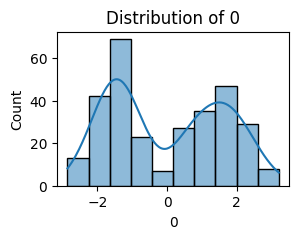

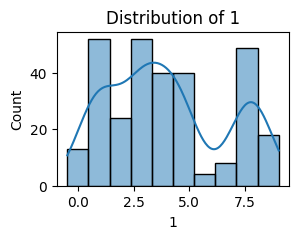

In [20]:
# Visualize the distribution of the first few variables
for column in data.columns[:5]:  # Adjust the range as needed
    plt.figure(figsize=(3, 2))
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

#### Use `sns.scatterplot(...)` to plot the two columns of blobs data:

<Axes: xlabel='0', ylabel='1'>

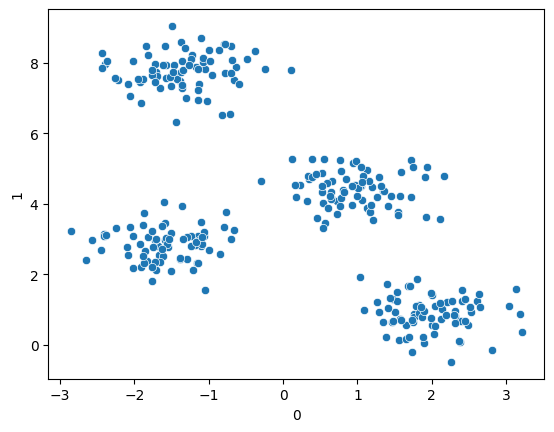

In [21]:
# Insert your code here:
sns.scatterplot(data=data, x=0, y=1)

<details><summary><span style="color:red">&#x1F6C8; Help</span> (Use this only as a last resort!!)</summary>

```Python
sns.scatterplot(data=data, x=0, y=1)
```

</details>


<details><summary><span style="color:blue">&#x1F6C8; Hint</span></summary>

Find the Library of Helper Functions code at the top.
```Pytho

# _show_confusion_matrix( ... )
```

</details>

##### Prepare Data for Clustering (Only `X` data, no `y`)
In unsupervised modelling we generally have no "external" measurement of validity. Therefore we have no way to evaluate the model on external data; therefore no need to split train and test sets.

In [22]:
X = data

#### Choose whether data pre-preprocessing (*numeric feature* `Scaling` or *categorical feature* `Encoding`) is required and apply it to the `X` data:

- Scale the selected data (`X` only) for modelling, encode and handle missing values.

In [23]:
from sklearn.preprocessing import StandardScaler

X_encoded = one_hot_encode(X, ['col'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Choose a clustering algorithm to `fit( ... )`

* Choose a `model = ... ()` and `model.fit( ... )` on the training data.
* For now, choose a `KMeans(..)` model, with parameter `n_clusters=4`.

In [24]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=4)
model = model.fit(X_scaled)

<details><summary><span style="color:red">&#x1F6C8; Help</span> (Use this only as a last resort!!)</summary>

```Python
model = KMeans(n_clusters=4)
model = model.fit(X_scaled)
```

</details>


#### Get the predicted `cluster labels` from the model and add as a new column in the original dataframe:

In [25]:
labels = model.labels_
print('Unique Labels', np.unique(labels), f'\t data_n={len(data)}, Cluster_n={len(labels)}' )
data['Cluster Label'] = pd.Series(labels, index=data.index[:len(labels)])

Unique Labels [0 1 2 3] 	 data_n=300, Cluster_n=300


#### Use sns.scatterplot adding colors for the `Cluster Label` column:

<Axes: xlabel='0', ylabel='1'>

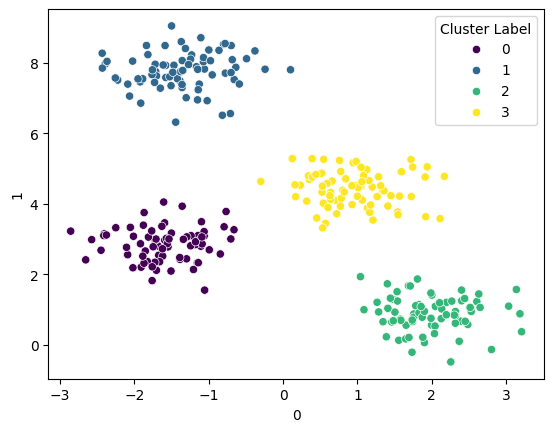

In [26]:
sns.scatterplot(data=data, x=0, y=1, hue='Cluster Label', palette='viridis')

#### Nice! Let's measure the best number of blobs using Parameter Search and the `Elbow Method`:
- We created 4 blobs in the dataset, so that's why we picked `n_clusters=4`.
- We can let the data decide for us by measuring the `Within-Cluster Sum of Squares (WCSS)` metric (as part of KMeans).

**Interpretation:** 
- An `inflection point` (or `"elbow"`) is where the rate of decrease in WCSS sharply changes. At that point is the best choice for number of clusters. Below you shold find that the "elbow" is at 4 clusters.
    - `KMeans` has its `model.inertia_` value.
    - `GMM` has its `model.aic` and `model.bic` values, which can be interpreted by the inflection point.

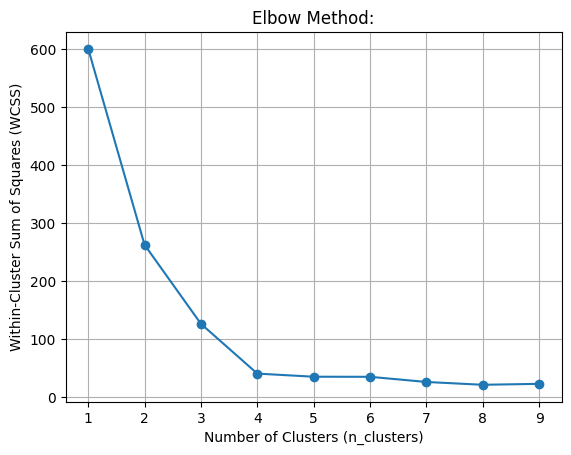

In [27]:
n_clusters_range = range(1,10)
wcss = []
for n_clusters in n_clusters_range:
    model = KMeans(n_clusters=n_clusters)
    model.fit(X_scaled)
    wcss.append(model.inertia_)  # inertia_ is the WCSS
    
_plot_wcss_elbow_method(n_clusters_range, wcss)

#### Parameter Search & `Silhouette Score`:

- Using a hyperparameter grid search, we can explore the `silhouette` metric score for different model parameter values, and choose the best performing parameter configuration:

#### Important Note:
- In the Lab Assignment you will need to use `Parameter Search & Silhouette Score:` code a few times.
- Parameters are mentioned in the slides:
    - KMeans uses the `n_clusters=2` parameter (int), e.g. in range `range(1,15,1)` (ints).
    - GMM uses the `n_components=2` parameter (int), e.g. in range `range(1,15,1)` (ints).
    - DBScan uses the `eps=0.2` parameter (float), e.g. in range `np.arange(0.1,2,0.05)` (floats).
- The Parameter Search process for each algorithm is the same:
  1. Try a range of parameter values.
  2. Collect the results.
  3. Get the best value.
  4. Use the best parameter value (as an int `int(best)` or as a float `float(best)`).

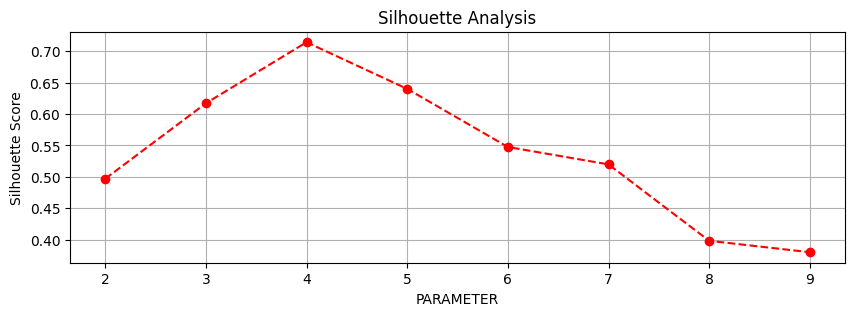

,Param,Silhouette Score
3,4.0,0.714117
4,5.0,0.639882
2,3.0,0.617029
5,6.0,0.547487
6,7.0,0.519797
1,2.0,0.496953
7,8.0,0.398250
8,9.0,0.380095


Best Parameter is:  4.0


4.0

In [28]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
n_clusters_range = range(1,10)
for n_clusters in n_clusters_range:
    model = KMeans(n_clusters=n_clusters)
    model.fit(X_scaled)
    labels = model.labels_
    if len(np.unique(labels))>1:
        score = silhouette_score(X_scaled, labels)
    else:
        score = float('nan')
    silhouette_scores += [ score ]

def get_best( param_range, silhouette_scores ):
    dfr = pd.DataFrame([n_clusters_range, silhouette_scores]).T.rename(columns={0:'Param', 1:'Silhouette Score'}).sort_values(by=['Silhouette Score'], ascending=False).dropna()
    display(dfr)
    best =  dfr.iloc[0].Param
    print('Best Parameter is: ',best)
    return best

_plot_sihouette_score(silhouette_scores, param_range=n_clusters_range, param_name='Parameter')
best = get_best( n_clusters_range, silhouette_scores )
best

- Now we have found the best parameter value, we can use it to re-fit the model:

In [29]:
print('Using Best Parameter:', best)
model = KMeans(n_clusters=int(best))
model.fit(X_scaled)
labels = model.labels_
print('Unique Labels', np.unique(labels), f'\t Data_n={len(data)}, Cluster_n={len(labels)}' )
data['Cluster Label'] = pd.Series(labels, index=data.index[:len(labels)])

Using Best Parameter: 4.0
Unique Labels [0 1 2 3] 	 Data_n=300, Cluster_n=300


<Axes: xlabel='0', ylabel='1'>

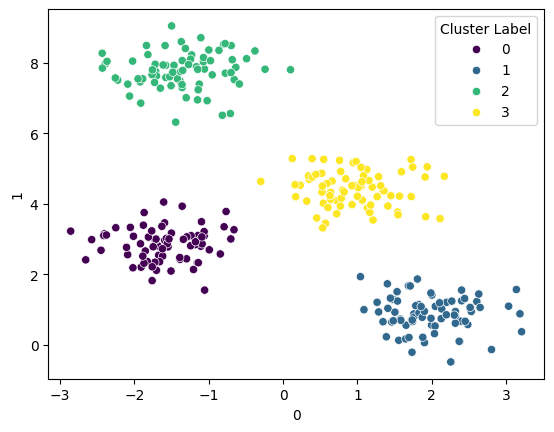

In [30]:
sns.scatterplot(data=data, x=0, y=1, hue='Cluster Label', palette='viridis')

#### Good job! Let's further visualize these clusters:

- Another visual-aid is to show the `cluster centroid` (center) and `line` distances from each point to its cluster center.

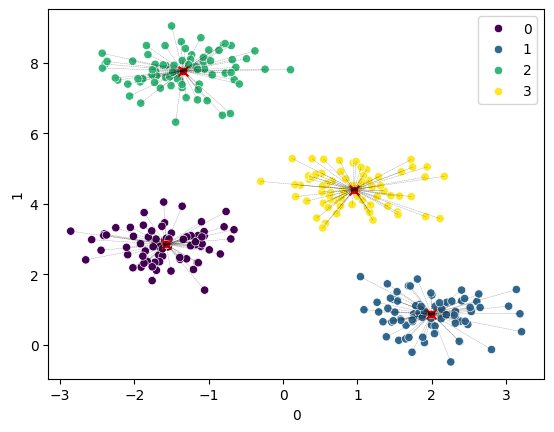

In [31]:
centroid_points = get_centroids_from_clusters(data[[0,1]], labels)
sns.scatterplot(data=data, x=0, y=1, hue='Cluster Label', palette='viridis')
sns.scatterplot(data=pd.DataFrame(centroid_points), x=0, y=1, color='red')
_plot_centroid_lines(data, labels)

- `Voronoi Cells Diagram` (spatial-partitioning-diagrams) also can visualize segmentations of clustered groups.

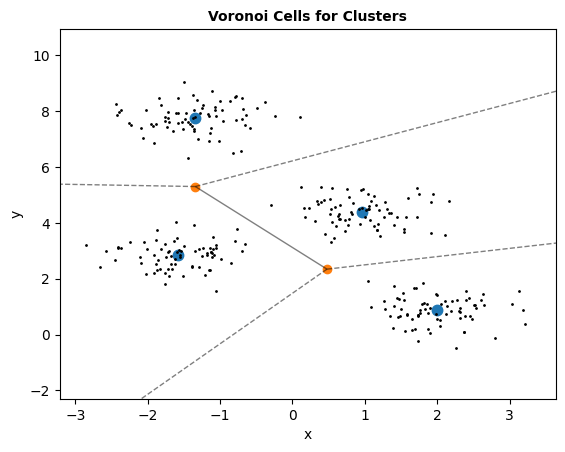

In [32]:
points = data[[0,1]].to_numpy()
_plot_voronoi_2d(points,  labels)

```

















```

```






```
<p style="text-align:center;">That's it! Congratulations! <br>     
    Now, let's move to today's Lab Assignment.</p>